# Generar Corpus en base a títulos de IL sobre Salud (IL)


## NLP para IL - proyectos de ley 
#### Preprocesamiento de textos

La normalización de texto es un proceso que transforma el texto a un formato estándar. Es un paso previo importante en el procesamiento del lenguaje natural:

Esto fue realizado en script:

* ✅ Eliminar  carácteres como puntos, comas, comillas, espacios, brackets, etc.
* ✅ Convertir los números a su equivalente a palabras
* ✅ Convertir a minúsculas
* ✅ Lematizar
* ✅ Remover stopwords (opcional)

Esto se analizará en esta notebook  
* ✅ Identificar palabras asociadas a dominio de las leyess
* ✅ Filtrar palabras asociadas a dominio

Tokenization: Tarea de dividir grandes cadenas de texto solo y exclusivamente en palabras.

Se guardará aqué el corpus IL 

In [1]:
# Importar librerias
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import pickle
import sweetviz as sv
import sys

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib import colormaps

from collections import Counter
from itertools import islice

In [2]:
### CONFIGURACION
load_dotenv() # Cargar las variables de entorno del archivo .env
BASE_DIR =  os.getenv("DIR_BASE")
RESULTADOS_DIR = os.getenv("DIR_DATOS_PROCESADOS") # Acceder a las variables de entorno
sys.path.append(BASE_DIR)
sys.path.append(RESULTADOS_DIR)

pd.set_option('display.max_colwidth', None)

## 1 - Recolección de textos preprocesados en script

In [3]:
with open(RESULTADOS_DIR + 'texto_normalizado_2009_2024_df.pkl', 'rb') as file: # textos procesados
    texto_df = pickle.load(file)

In [4]:
texto_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Proyecto.ID,35179,35179,HCDN246858,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Título,35179,33168,JUICIO POR JURADOS. CREACION.,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Título procesado,35179,29558,contrato de trabajo ley numero modificacion del articulo numero sobre licencias especiales,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Título normalizado,35179,28746,licencia especial,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cant_token,35179.0,NaN,NaN,NaN,21.123682,10.69187,2.0,14.0,19.0,27.0,125.0
Cant_token_normalizado,35179.0,NaN,NaN,NaN,9.429375,5.019535,0.0,6.0,8.0,12.0,53.0


## 2 -Limpieza y preparación de los datos (dominio de datos) 

In [5]:
# Librerias para texto
import re
import nltk
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

# https://pypi.org/project/textacy/
import textacy
import textacy.preprocessing as tprep
from src.nlp import limpiar_texto_legislativo

In [6]:
texto_df.head(4)

,Proyecto.ID,Título,Título procesado,Título normalizado,Cant_token,Cant_token_normalizado
0,HCDN280534,"ANULENSE LOS DECRETOS 1107/2024 Y 1112/2024, SOBRE MODIFICACIONES EN LAS FUNCIONES DE LAS FUERZAS ARMADAS - FFAA -.",anulense los decretos numero numero y numero numero sobre modificaciones en las funciones de las fuerzas armadas ffaa,anulense decreto modificacion funcion fuerza armado ffaa,18,7
2,HCDN280533,DEFENSA DEL CONSUMIDOR - LEY 24240 -. MODIFICACION DEL ARTICULO 8 SOBRE IMAGENES HUMANAS EN PUBLICIDADES.,defensa del consumidor ley numero modificacion del articulo numero sobre imagenes humanas en publicidades,defensa consumidor imagen humano publicidad,16,5
5,HCDN280532,DEFENSA DEL CONSUMIDOR - LEY 24240 -. MODIFICACION DEL ARTICULO 8 BIS SOBRE TRATO DIGNO Y PRACTICAS ABUSIVAS.,defensa del consumidor ley numero modificacion del articulo numero bis sobre trato digno y practicas abusivas,defensa consumidor bis trato digno practica abusivo,18,7
6,HCDN280531,CODIGO CIVIL Y COMERCIAL DE LA NACION - LEY 26994 -. MODIFICACIONES SOBRE CONTRATOS DE LOCACION-.,codigo civil y comercial de la nacion ley numero modificaciones sobre contratos de locacion,contrato locacion,16,2


Los títulos de los IL presentan entre 0 y 600 caracteres.

<Axes: >

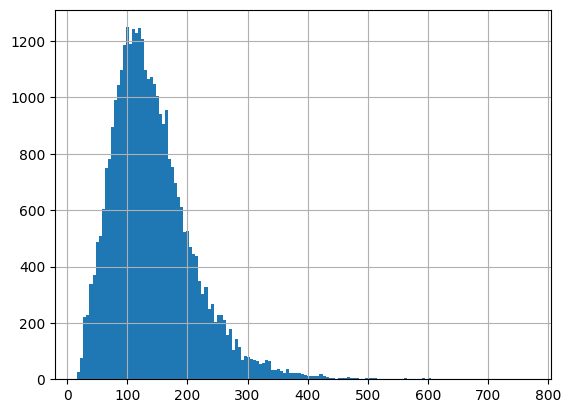

In [7]:
texto_df['Título'].str.len().hist(bins='auto')

In [8]:
texto_df['Título'].str.len().describe()

count    35179.000000
mean       141.915916
std         68.470295
min         17.000000
25%         94.000000
50%        130.000000
75%        177.000000
max        767.000000
Name: Título, dtype: float64

Los títulos de los IL presenta en promedio 27 palabras, min 2 palabras max 217 palabras.

<Axes: >

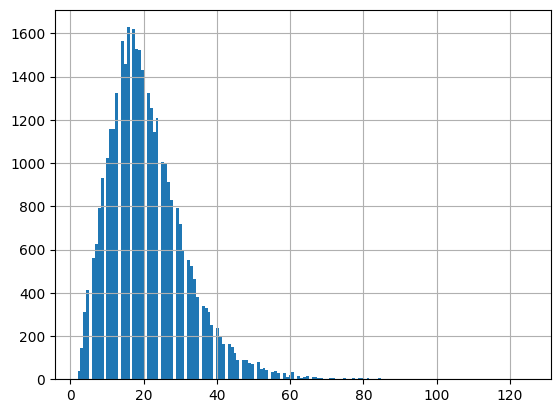

In [9]:
texto_df['Título'].str.split().map(lambda x: len(x)).hist(bins='auto')

In [10]:
texto_df['Título'].str.split().map(lambda x: len(x)).describe()

count    35179.000000
mean        21.123682
std         10.691870
min          2.000000
25%         14.000000
50%         19.000000
75%         27.000000
max        125.000000
Name: Título, dtype: float64

**Controlando errores: ¿títulos vacios?**

In [11]:
texto_df[texto_df['Título procesado']==" "] # Contiene la limpieza básica 

,Proyecto.ID,Título,Título procesado,Título normalizado,Cant_token,Cant_token_normalizado


In [12]:
texto_df[texto_df['Título normalizado']==" "].shape

(5, 6)

**Validando Normalización**

In [13]:
# Chequeamos el proceso normalizado
MODELO_NLP = spacy.load("es_core_news_md")
texto_orig = "GESTACION POR SUSTITUCION. REGIMEN. MODIFICACION DE LOS CODIGOS CIVIL Y COMERCIAL DE LA NACION Y PENAL DE LA NACION"
#texto_orig = texto_df[texto_df['Título normalizado']==""]['Título'].values[0]
texto = limpiar_texto_legislativo.limpiar_texto_basico(texto_orig)

In [14]:
doc = MODELO_NLP(texto)
etiquetas_permitidas=['NOUN', 'ADJ', 'VERB', 'ADV']
minimo_caracteres = 1
for token in doc:
    print(token,token.pos_,token.lemma_)
    if token.lemma_ not in ['-PRON-']:
        token_lem = token.lemma_
    else:
        token_lem = ""
    if len(token_lem.strip()) > 0:
        if not (token_lem in STOP_WORDS):
            if len(token_lem) > minimo_caracteres:
                print("********") # token_lem

gestacion PROPN gestacion
********
por ADP por
sustitucion PROPN sustitucion
********
regimen PROPN regimen
********
modificacion PROPN modificacion
********
de ADP de
los DET el
codigos PROPN codigos
********
civil ADJ civil
********
y CCONJ y
comercial ADJ comercial
********
de ADP de
la DET el
nacion PROPN nacion
********
y CCONJ y
penal PROPN penal
********
de ADP de
la DET el
nacion PROPN nacion
********


#### Reducción de ruido en términos genéricos

Si ciertos n-gramas son muy frecuentes en todos los textos y no aportan información (ej. "en el año"), eliminarlos ayuda a que los embeddings reflejen conceptos más específicos del dominio.

Un n-grama es una secuencia de n elementos consecutivos de un texto o discurso. Los elementos pueden ser palabras, números, símbolos, fonemas, sílabas, letras, o pares de bases. 


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear bigramas y trigramas
vectorizer = CountVectorizer(ngram_range=(2,5), min_df=5) # Para n-gramas raros , si consideramos min_df = 1, p90=4
X = vectorizer.fit_transform(texto_df["Título normalizado"])
n_gramas = vectorizer.get_feature_names_out()
frecuencias = X.sum(axis=0).A1
df_ngrams = pd.DataFrame({'ngram': n_gramas, 'frecuencia': frecuencias})
df_ngrams = df_ngrams.sort_values(by='frecuencia', ascending=False)

In [ ]:
df_ngrams.describe() # Se observa n-gramas de n entre 2 a 5 más frecuentes


In [ ]:
df_ngrams.plot.box()

In [ ]:
umbral = df_ngrams['frecuencia'].quantile(0.95) # Eliminar n-gramas muy frecuentes (por encima del percentil 95)?

umbral

In [ ]:
# Mostrar top 50
print(df_ngrams.head(50))

# Visualizar
plt.figure(figsize=(12,6))
sns.barplot(data=df_ngrams.head(50), x='frecuencia', y='ngram', palette='viridis')
plt.title("Top 20 n-gramas más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("n-grama")
plt.tight_layout()
plt.show()

In [ ]:
df_ngrams = df_ngrams.head(12)
df_ngrams["n"] = df_ngrams['ngram'].str.split().map(lambda x: len(x))
df_ngrams = df_ngrams.sort_values("n", ascending = False)
df_ngrams

In [ ]:
ngramas_a_eliminar = list(df_ngrams['ngram'].values) # Eliminar los top  12
# Crear un solo patrón con regex
patron = r'\b(' + '|'.join(map(re.escape, ngramas_a_eliminar)) + r')\b'
patron

In [ ]:
texto_df['Título normalizado'] = texto_df['Título normalizado'].str.replace(patron, '', regex=True)

In [ ]:
texto_df[texto_df['Título normalizado']==" "]

## 3 - Analizando corpus

In [15]:
texto_df['Cant_token'] = texto_df['Título'].str.split().map(lambda x: len(x))
texto_df['Cant_token_normalizado'] = texto_df['Título normalizado'].str.split().map(lambda x: len(x))

,count,mean,std,min,25%,50%,75%,max
Cant_token,35179.0,21.123682,10.691870,2.0,14.0,19.0,27.0,125.0
Cant_token_normalizado,35179.0,9.429375,5.019535,0.0,6.0,8.0,12.0,53.0


<Axes: >

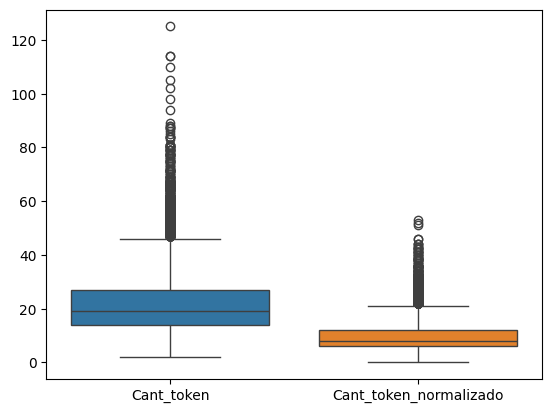

In [16]:
# Distribución
display(texto_df[['Cant_token','Cant_token_normalizado']].describe().T)
sns.boxplot(data=texto_df[['Cant_token','Cant_token_normalizado']])


¿Títulos vacios?

In [17]:
# Error
Error_texto = texto_df[texto_df['Cant_token_normalizado']<1].copy()
#Error_texto['Título normalizado'] = Error_texto['Título'].apply(limpieza_basica_texto) 

In [18]:
Error_texto.shape

(6, 6)

In [20]:
Error_texto

,Proyecto.ID,Título,Título procesado,Título normalizado,Cant_token,Cant_token_normalizado
19959,HCDN247803,IMPUESTO A LAS GANANCIAS - LEY 20628 -. MODIFICACIONES.,impuesto a las ganancias ley numero modificaciones,,9,0
20116,HCDN247562,IMPUESTO A LAS GANANCIAS - LEY 20628 -. MODIFICACIONES.,impuesto a las ganancias ley numero modificaciones,,9,0
29145,HCDN233308,MODIFICACION DE LA LEY DE CONTRATO DE TRABAJO - LEY 20744 -. (REPRODUCCION DEL EXPEDIENTE 2937-D-17).,modificacion de la ley de contrato de trabajo ley numero reproduccion del expediente numero d numero,,16,0
31667,HCDN228000,CODIGO PENAL - LEY 11179 - MODIFICACION DEL ARTICULO 185.,codigo penal ley numero modificacion del articulo numero,,10,0
41848,HCDN200160,MODIFICACION DE LA LEY DE CONTRATO DE TRABAJO - LEY 20744 -.,modificacion de la ley de contrato de trabajo ley numero,,12,0
41850,HCDN200168,MODIFICACION DE LA LEY DE CONTRATO DE TRABAJO - LEY 20744 -.,modificacion de la ley de contrato de trabajo ley numero,,12,0


Exploramos por período


In [21]:
with open(RESULTADOS_DIR + 'proyecto_2009_2024_LIMPIO2_df.pkl', 'rb') as file: # textos procesados
    proyecto_2009_2024_df = pickle.load(file)


In [22]:
base_texto_df = pd.merge(texto_df,proyecto_2009_2024_df[['Proyecto.ID','Proyecto_SALUD','Resultado','Periodo']], how = 'inner',left_on = 'Proyecto.ID', right_on='Proyecto.ID' )

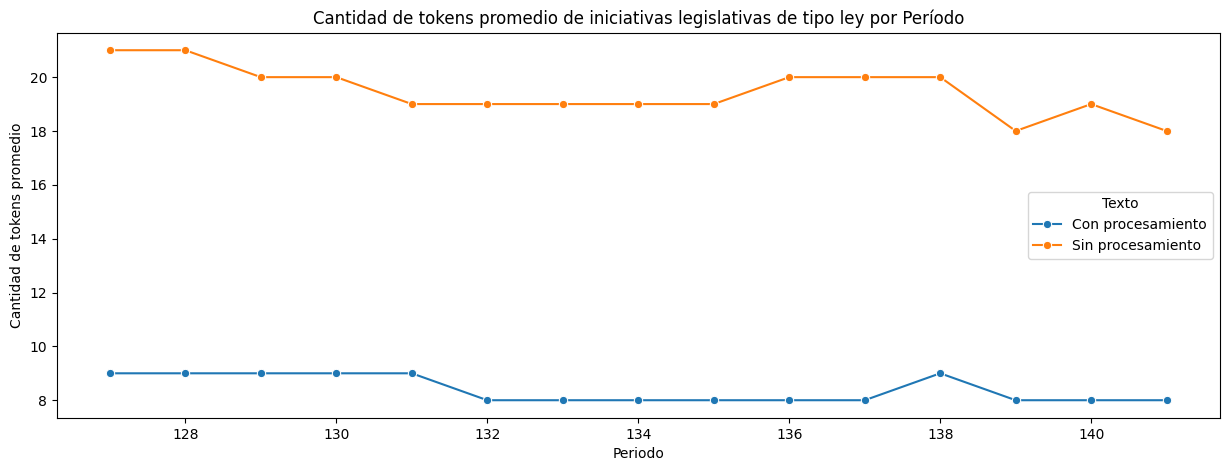

In [23]:
import matplotlib.ticker as ticker
sns.color_palette("pastel")

Temp = pd.pivot_table(base_texto_df, values=['Cant_token','Cant_token_normalizado'], index=['Periodo'],
                       aggfunc={'Cant_token': 'median','Cant_token_normalizado': 'median'}).reset_index()
Temp = pd.melt(Temp, id_vars=['Periodo'], value_vars=['Cant_token_normalizado', 'Cant_token'])
Temp.columns = ['Periodo','Texto','Cantidad de tokens promedio']
Temp["Texto"] = Temp["Texto"].map({'Cant_token': 'Sin procesamiento', 'Cant_token_normalizado': 'Con procesamiento'})

f, ax = plt.subplots(1, 1, figsize=(15, 5), sharey = True)
sns.lineplot(x='Periodo', y='Cantidad de tokens promedio', hue='Texto', data = Temp, estimator='sum', errorbar= None , linestyle='-', ax = ax, marker="o")
legend_handles, _= ax.get_legend_handles_labels()

ax.set_title('Cantidad de tokens promedio de iniciativas legislativas de tipo ley por Período')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=15))
plt.savefig(BASE_DIR+"imagenes/evolucion_IL_periodo_tokens.png")
plt.show()


Exploramos por resultado

In [24]:
pd.pivot_table(pd.merge(texto_df,proyecto_2009_2024_df[['Proyecto.ID','Proyecto_SALUD','Resultado','Periodo']], how = 'inner',left_on = 'Proyecto.ID', right_on='Proyecto.ID' ), values=['Cant_token','Cant_token_normalizado'], index=['Resultado'],
                       aggfunc={'Cant_token': ('mean','median',"min","max"),'Cant_token_normalizado': ('mean','median',"min","max")}).reset_index()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4548\1633866146.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pd.pivot_table(pd.merge(texto_df,proyecto_2009_2024_df[['Proyecto.ID','Proyecto_SALUD','Resultado','Periodo']], how = 'inner',left_on = 'Proyecto.ID', right_on='Proyecto.ID' ), values=['Cant_token','Cant_token_normalizado'], index=['Resultado'],


Resultado Cant_token                    \
                                                    max       mean median   
0                                   APROBADO       44.0  24.000000   22.0   
1                              MEDIA SANCION       79.0  22.113001   20.0   
2  NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN      125.0  21.095541   19.0   
3                                   RETIRADO       34.0  31.333333   34.0   
4                                 SANCIONADO       44.0  20.454545   18.0   
5   SIN INFORMACIÓN DE RESULTADO DE PROYECTO       39.0  23.818182   24.0   

        Cant_token_normalizado                          
    min                    max       mean median   min  
0  12.0                   23.0  11.500000   11.0   7.0  
1   2.0                   42.0  10.238153    9.0   1.0  
2   2.0                   53.0   9.406531    8.0   0.0  
3  26.0                   14.0  12.333333   12.0  11.0  
4   5.0                   22.0   8.878788    9.0   3.0  
5   6.0                   22.0  11.931818   11.5   4.0

#### Creacción del diccionario y la bolsa de palabras (BoW)
En este punto tenemos que crear:
* Corpus tokenizado: "documents_tok"
* Diccionario: "dictionary"
* Corpus: "corpus' que es la bolsa de palabras de gensim
* Detectar palabras asociado al dominio (leyes) para eliminar

In [26]:
# https://github.com/RicardoMoya/NLP_with_Python/blob/master/21_Topic_Modeling_noticias.ipynb
# https://github.com/RicardoMoya/NLP_with_Python/blob/master/05_Bag_of_Words_BoW.ipynb

#import gensim
#import gensim.corpora as corpora
from pprint import pprint
#from gensim import corpora
from collections import defaultdict
from collections import Counter


,frecuencia
count,12865.000000
mean,25.784376
std,149.057428
min,1.000000
25%,1.000000
50%,3.000000
75%,10.000000
max,8779.000000


Text(0.5, 1.0, 'Top 50 palabras más frecuentes')

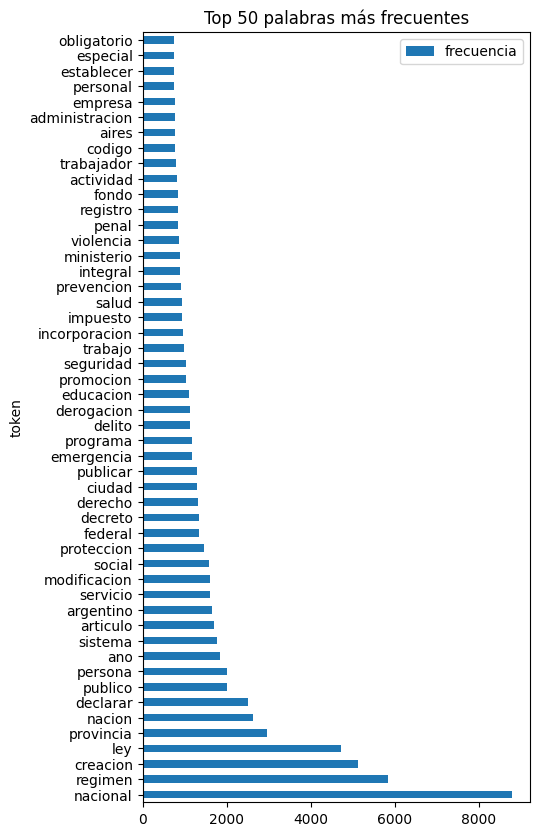

In [27]:
##################################PASOS DICCIONARIO########################
corpus_norm = list(texto_df['Título normalizado'])
# Tokenizamos
documents_tok = [word.split() for word in corpus_norm]

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in documents_tok:
    for token in doc:
        frequency[token] += 1

# Exploramos todas las palabras para limpiar mejor
#counter = Counter(frequency)
frecuencia_df = pd.DataFrame.from_records(list(frequency.items()), columns = ['token','frecuencia'])
display(frecuencia_df.describe())

fig, ax = plt.subplots(figsize=(5, 10))
frecuencia_df.sort_values('frecuencia', ascending=False).head(50).plot(kind='barh', x = 'token', ax=ax)
ax.set_title('Top 50 palabras más frecuentes')


<Axes: >

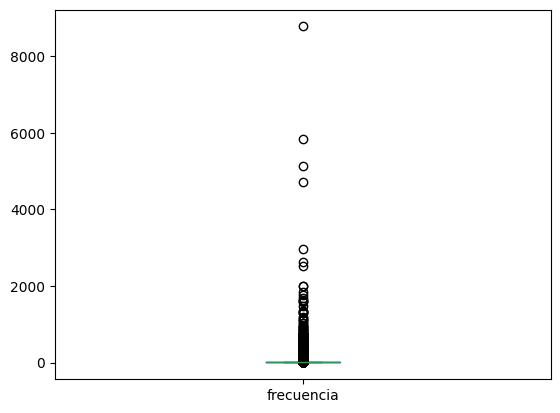

In [28]:
frecuencia_df['frecuencia'].plot(kind='box')


In [29]:
# Librerias para texto
import gensim
from gensim.corpora import Dictionary

In [30]:
# Tokenizamos
diccionario = Dictionary(documents_tok)

In [31]:
diccionario

In [32]:
# Diccionario
print('Diccionario Inicial: ', len(diccionario))
print(format(diccionario))

# Diccionario con más de 3 palabras (media) y con presencia de 20%
diccionario.filter_extremes(no_below=3, no_above=0.2)
diccionario.compactify()
print('Diccionario Filtrado: ', len(diccionario))
#print(dictionary.token2id)

# Creamos la Bolsa de Palabras
BoW_corpus = [diccionario.doc2bow(doc) for doc in documents_tok]
print('\nPrimer Documento del Corpus:\n{}'.format(BoW_corpus[0]))

Diccionario Inicial:  12865
Dictionary<12865 unique tokens: ['anulense', 'armado', 'decreto', 'ffaa', 'fuerza']...>
Diccionario Filtrado:  6729

Primer Documento del Corpus:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [33]:
# Guardamos
pickle.dump(diccionario, open(RESULTADOS_DIR + "diccionario_ley_0924.pkl", "wb"))
pickle.dump(BoW_corpus, open(RESULTADOS_DIR + 'BoW_corpus_ley_0924.pkl', 'wb'))


In [34]:
import pickle

with open(RESULTADOS_DIR + 'texto_normalizado_2009_2024_df.pkl', 'wb') as file:
    pickle.dump(texto_df,file)

#### Term Frequency-Inverse Document Frequency (TF-IDF)

El TF-IDF (Frecuencia de Termino - Frecuencia Inversa de Documento) es una medida numérica que permite expresar como de relevante es una palabra para un documento en una colección de documentos (o corpus).

Construir la Bolsa de Palabras con TF-IDF en vez de con frecuencias evita dar "importancia" a texto muy largos y con mucha repetición de palabras, frente a textos cortos y con pocas repeticiones de palabras.


In [35]:
from gensim.models import TfidfModel

# Creamos la Bolsa de Palabras con TF-ID
#BoW_corpus = [dictionary.doc2bow(doc) for doc in documents]
tfidf = TfidfModel(BoW_corpus, smartirs='ntc')
tfidf_corpus  = [tfidf[diccionario.doc2bow(doc)] for doc in documents_tok]

# Resultados
print('Diccionario de palabras -> palabra: id\n')
#print(dictionary_tfidf.token2id)
print('\nApariciones de las palabras en los documentos (id, tfidf):')
#tfidf_corpus

Diccionario de palabras -> palabra: id


Apariciones de las palabras en los documentos (id, tfidf):


In [36]:
# Guardamos
pickle.dump(tfidf_corpus, open(RESULTADOS_DIR+'tfidf_corpus_ley_0923.pkl', 'wb'))

In [37]:
base_texto_df = pd.merge(texto_df,proyecto_2009_2024_df[['Proyecto.ID','Proyecto_girado_a_comisiones_SALUD','Proyecto_SALUD','Resultado','Max_Orden','Tiene_antecedente_por_titulo_proy','Periodo','Año']], how = 'inner',left_on = 'Proyecto.ID', right_on='Proyecto.ID' )

In [38]:
from tqdm import tqdm

base_texto_df['Tokens'] = base_texto_df['Título normalizado'].apply(lambda x: x.split()) #list of lists

In [39]:
base_texto_df[['Título','Tokens']].head(5)

,Título,Tokens
0,"ANULENSE LOS DECRETOS 1107/2024 Y 1112/2024, SOBRE MODIFICACIONES EN LAS FUNCIONES DE LAS FUERZAS ARMADAS - FFAA -.","[anulense, decreto, modificacion, funcion, fuerza, armado, ffaa]"
1,DEFENSA DEL CONSUMIDOR - LEY 24240 -. MODIFICACION DEL ARTICULO 8 SOBRE IMAGENES HUMANAS EN PUBLICIDADES.,"[defensa, consumidor, imagen, humano, publicidad]"
2,DEFENSA DEL CONSUMIDOR - LEY 24240 -. MODIFICACION DEL ARTICULO 8 BIS SOBRE TRATO DIGNO Y PRACTICAS ABUSIVAS.,"[defensa, consumidor, bis, trato, digno, practica, abusivo]"
3,CODIGO CIVIL Y COMERCIAL DE LA NACION - LEY 26994 -. MODIFICACIONES SOBRE CONTRATOS DE LOCACION-.,"[contrato, locacion]"
4,CODIGO CIVIL Y COMERCIAL DE LA NACION - LEY 26994 -. MODIFICACION DEL ARTICULO 1098 SOBRE PROTECCION DEL CONSUMIDOR.,"[proteccion, consumidor]"


In [41]:
# Para entender mejor un diccionario de palabras con peso por tf idf
# https://weiliu2k.github.io/CITS4012/gensim/tf-idf.html
# https://github.com/simplykeerthana/WordCloud-Generator/blob/main/word_cloud_gen.ipynb


def obtener_dic_nubepalabras(documents1,dictionary):
    dic = {}
    for i, doc in enumerate(documents1):
        for idx, freq in tfidf[dictionary.doc2bow(doc)]:
            key = dictionary[idx]
            if key in dic:
                dic[key] += np.around(freq,decimals=2)
            else:
                dic[key] = np.around(freq,decimals=2)
    return dic
                
 

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


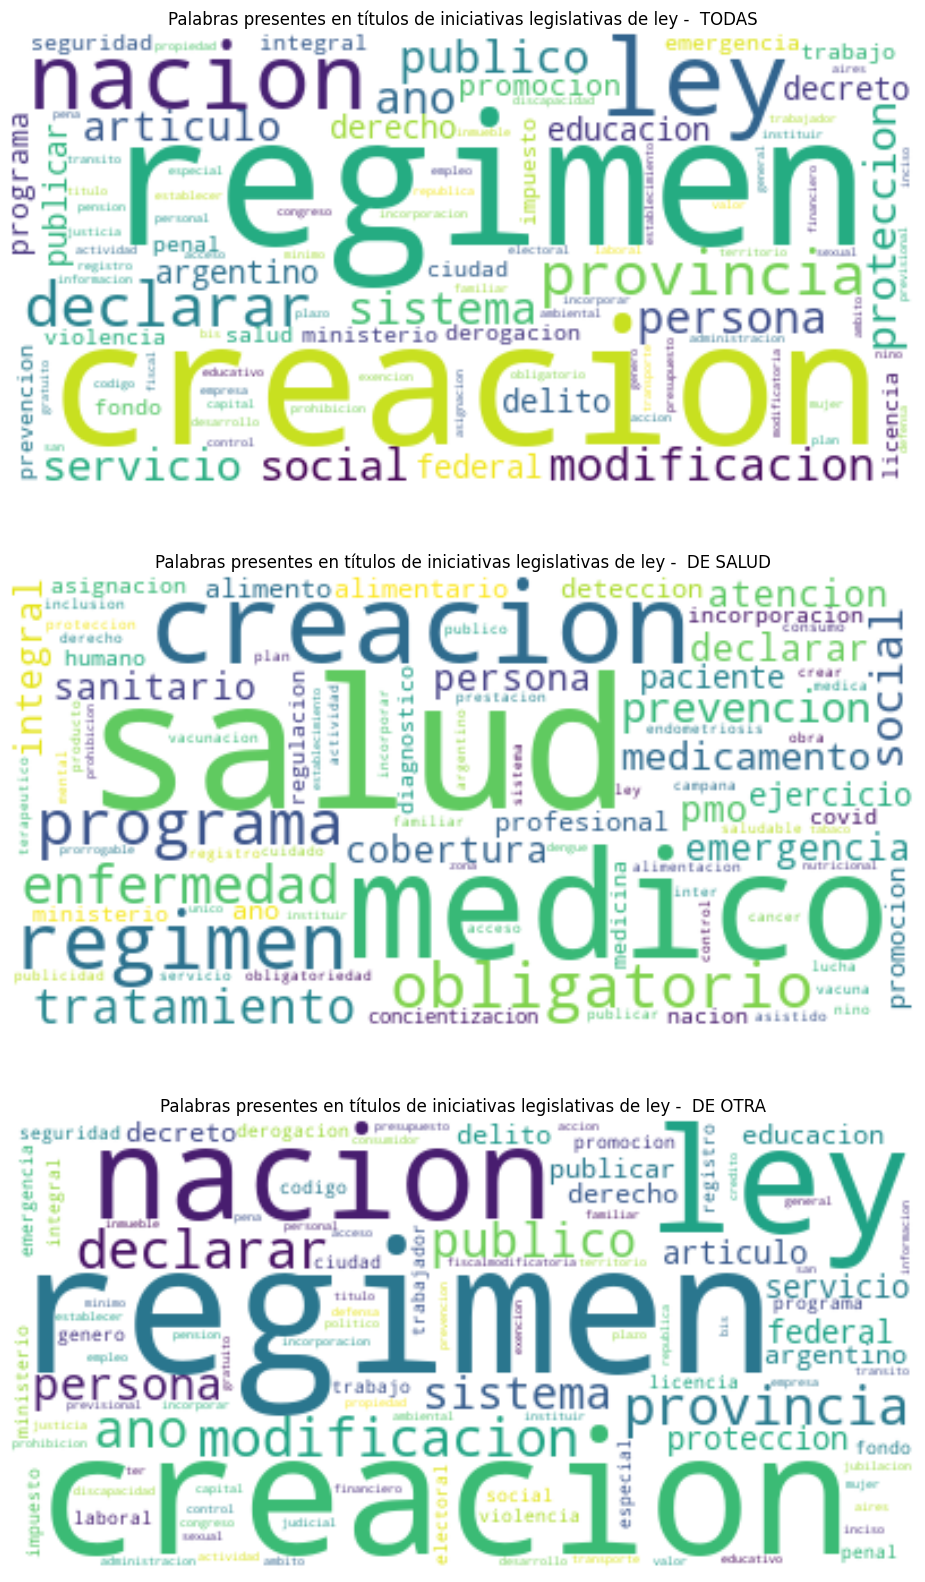

In [44]:
# Todo
dic_all = obtener_dic_nubepalabras(documents_tok,diccionario)

# Salud
documentos_tokens_temp = list(base_texto_df[base_texto_df['Proyecto_SALUD']==1]['Tokens'])
dic_salud = obtener_dic_nubepalabras(documentos_tokens_temp,diccionario)

# Otras
documentos_tokens_temp = list(base_texto_df[base_texto_df['Proyecto_SALUD']==0]['Tokens'])
dic_otras = obtener_dic_nubepalabras(documentos_tokens_temp,diccionario)

words_comisiones = {
    ' Todas': dic_all,
    ' De salud': dic_salud,
    ' De otra':dic_otras
}

plt.figure(figsize=(25, 20))
pos = 1
for key, words in words_comisiones.items():
    plt.subplot(3, 1, pos)
    wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").fit_words(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras presentes en títulos de iniciativas legislativas de ley - {}".format(key.upper()))
    plt.savefig(BASE_DIR+"imagenes/"+key.replace(" ", "_")+".png")
    pos += 1
plt.show()



¿Qué proyectos que no pasaron en primera instancia por comisión de Salud, tiene asociado la palabra reproducción?

In [45]:
base_texto_df.columns

Index(['Proyecto.ID', 'Título', 'Título procesado', 'Título normalizado',
       'Cant_token', 'Cant_token_normalizado',
       'Proyecto_girado_a_comisiones_SALUD', 'Proyecto_SALUD', 'Resultado',
       'Max_Orden', 'Tiene_antecedente_por_titulo_proy', 'Periodo', 'Año',
       'Tokens'],
      dtype='object')

In [46]:
reprod_df = base_texto_df.loc[(base_texto_df['Proyecto_SALUD']==0) & (base_texto_df['Título normalizado'].str.contains('reproduccion')== True),['Proyecto.ID', 'Título','Tokens','Proyecto_SALUD','Proyecto_girado_a_comisiones_SALUD']]

In [47]:
reprod_df.head()

,Proyecto.ID,Título,Tokens,Proyecto_SALUD,Proyecto_girado_a_comisiones_SALUD
589,HCDN277771,PROPIEDAD INTELECTUAL - LEY 11723 -. MODIFICACION DEL ARTICULO 36 SOBRE EXENCION DEL PAGO DEL DERECHO DE AUTOR A LAS REPRODUCCIONES MUSICALES U OTRAS OBRAS ARTISTICAS EN HABITACIONES DE HOTELES Y HOSPEDAJES.,"[propiedad, intelectual, exencion, pago, derecho, autor, reproduccion, musical, obra, artistica, habitacion, hotel, hospedaj]",0.0,0.0
1108,HCDN275332,PROPIEDAD INTELECTUAL - LEY 11723 -. MODIFICACION DEL ARTICULO 36 SOBRE EXENCION DEL PAGO DEL DERECHO DE AUTOR A LAS REPRODUCCIONES MUSICALES U OTRAS OBRAS ARTISTICAS EN HABITACIONES DE HOTELES Y HOSPEDAJES.,"[propiedad, intelectual, exencion, pago, derecho, autor, reproduccion, musical, obra, artistica, habitacion, hotel, hospedaj]",0.0,0.0
1828,HCDN273153,"CODIGO PENAL DE LA NACION. INCORPORACION DEL ARTICULO 117 TER, SOBRE PUBLICACION, REPRODUCCION O DIFUSION DE IMAGENES, VIDEOS O DE VOZ CON CONTENIDO SEXUAL.","[nacion, ter, publicacion, reproduccion, difusion, imagen, videos, voz, contenido, sexual]",0.0,0.0
2168,HCDN272164,"PROPIEDAD INTELECTUAL - LEY 11723 -. MODIFICACION DEL ARTICULO 36, SOBRE EXENCION DEL PAGO DEL DERECHO DE AUTOR A LAS REPRODUCCIONES MUSICALES U OTRAS OBRAS ARTISTICAS EN HABITACIONES DE HOTELES Y HOSPEDAJES. DEROGACION DEL ARTICULO 33 DEL DECRETO 41223/34.","[propiedad, intelectual, exencion, pago, derecho, autor, reproduccion, musical, obra, artistica, habitacion, hotel, hospedaj, derogacion, articulo, decreto]",0.0,0.0
5686,HCDN256156,"CODIGO PENAL DE LA NACION. INCORPORACION DEL ARTICULO 117 TER, SOBRE PUBLICACION, REPRODUCCION O DIFUSION DE IMAGENES, VIDEOS O DE VOZ CON CONTENIDO SEXUAL.","[nacion, ter, publicacion, reproduccion, difusion, imagen, videos, voz, contenido, sexual]",0.0,0.0


In [48]:
reprod_df.describe(include = 'all')

,Proyecto.ID,Título,Tokens,Proyecto_SALUD,Proyecto_girado_a_comisiones_SALUD
count,34,34,34,34.0,34.000000
unique,34,32,26,NaN,NaN
top,HCDN167904,LICENCIA ESPECIAL PARA TRABAJADORES QUE REALICEN TRATAMIENTOS DE REPRODUCCION MEDICAMENTE ASISTIDA.,"[licencia, especial, trabajador, tratamiento, reproduccion, medicamente, asistido]",NaN,NaN
freq,1,2,3,NaN,NaN
mean,NaN,NaN,NaN,0.0,0.147059
std,NaN,NaN,NaN,0.0,0.359491
min,NaN,NaN,NaN,0.0,0.000000
25%,NaN,NaN,NaN,0.0,0.000000
50%,NaN,NaN,NaN,0.0,0.000000
75%,NaN,NaN,NaN,0.0,0.000000


### Común vocabulario por período

In [49]:
# Guardar - OJO CON LOS REGISTROS SIN PERIODO
pickle.dump(base_texto_df, open(RESULTADOS_DIR +'base_texto_df_ley_0924.pkl', 'wb'))

In [50]:
#Agrupar titulos por periodo
periodo_salud_original_df = base_texto_df[base_texto_df['Proyecto_SALUD']==1].groupby('Periodo')['Título'].apply(lambda x: ' '.join(x)).reset_index()
periodo_salud_normalizado_df = base_texto_df[base_texto_df['Proyecto_SALUD']==1].groupby('Periodo')['Título normalizado'].apply(lambda x: ' '.join(x)).reset_index()


In [51]:
periodo_salud_original_df.head(3)

Periodo  \
0    127.0   
1    128.0   
2    129.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [52]:
def paso_uno_pares(lista_items):
    return [(lista_items[i],lista_items[i+1]) for i in range(len(lista_items)-1)]

In [53]:
# Ordenar períodos según el número 
periodos = sorted(periodo_salud_original_df['Periodo'].to_list())
periodo_pares = paso_uno_pares(periodos)
print(periodo_pares)

[(127.0, 128.0), (128.0, 129.0), (129.0, 130.0), (130.0, 131.0), (131.0, 132.0), (132.0, 133.0), (133.0, 134.0), (134.0, 135.0), (135.0, 136.0), (136.0, 137.0), (137.0, 138.0), (138.0, 139.0), (139.0, 140.0), (140.0, 141.0)]


#### Calcular la intersección de vocabulario/token entre pares de períodos

In [54]:
# Sobre titulos sin limpieza
periodo_salud_original_df['vocab'] = periodo_salud_original_df['Título'].str.lower()
periodo_salud_original_df['vocab'] = periodo_salud_original_df['vocab'].str.split()
comun_vocab_list = []

for par in periodo_pares:
    
    s1 = set(periodo_salud_original_df.loc[(periodo_salud_original_df.Periodo==par[0])].vocab.values[0])
    s2 = set(periodo_salud_original_df.loc[(periodo_salud_original_df.Periodo==par[1])].vocab.values[0])
    comun_vocab = len(s1.intersection(s2))
    comun_vocab_list.append([par, comun_vocab])
    
comun_vocab_salud_original_df = pd.DataFrame(comun_vocab_list, columns = ['par', 'comun_vocab'])
# comun_vocabab_df_original.to_csv('../out_files/comun_vocabab_df_original.csv', index=False)
print(comun_vocab_salud_original_df.head(2))

              par  comun_vocab
0  (127.0, 128.0)          322
1  (128.0, 129.0)          324


In [55]:
comun_vocab_salud_original_df.to_csv(RESULTADOS_DIR+'archivos_out/comun_vocab_salud_original.csv', index=False)


In [56]:
periodo_salud_normalizado_df['vocab'] = periodo_salud_normalizado_df['Título normalizado'].str.split()
comun_vocab_norm_list = []

for par in periodo_pares:
    
    s1 = set(periodo_salud_normalizado_df.loc[(periodo_salud_normalizado_df.Periodo==par[0])].vocab.values[0])
    s2 = set(periodo_salud_normalizado_df.loc[(periodo_salud_normalizado_df.Periodo==par[1])].vocab.values[0])
    comun_vocab = len(s1.intersection(s2))
    comun_vocab_norm_list.append([par, comun_vocab])
    
comun_vocab_salud_norm_df = pd.DataFrame(comun_vocab_norm_list, columns = ['par', 'comun_vocab'])
# comun_vocabab_df_original.to_csv('../out_files/comun_vocabab_df_original.csv', index=False)
print(comun_vocab_salud_norm_df.head(2))

              par  comun_vocab
0  (127.0, 128.0)          260
1  (128.0, 129.0)          261


In [57]:
comun_vocab_salud_norm_df.to_csv(RESULTADOS_DIR+'archivos_out/comun_vocab_salud_norm.csv', index=False)


#### Visualizar vocabulario común

In [58]:
periodos = {
    127: (2009, 2010),
    128: (2010, 2011),
    129: (2011, 2012),
    130: (2012, 2013),
    131: (2013, 2014),
    132: (2014, 2015),
    133: (2015, 2016),
    134: (2016, 2017),
    135: (2017, 2018),
    136: (2018, 2019),
    137: (2019, 2020),
    138: (2020, 2021),
    139: (2021, 2022),
    140: (2022, 2023),
    141: (2023, 2024)
}

comun_vocab_salud_original_df['version'] = 'Sin procesamiento'
comun_vocab_salud_original_df['Periodo inicio'] = comun_vocab_salud_original_df['par'].map(lambda x: periodos[x[0]][0])
comun_vocab_salud_original_df['Periodo fin'] = comun_vocab_salud_original_df['par'].map(lambda x: periodos[x[1]][1])
comun_vocab_salud_original_df['Periodo intermedio'] = ((comun_vocab_salud_original_df['Periodo inicio'] 
                                        + comun_vocab_salud_original_df['Periodo fin']) / 2)

comun_vocab_salud_norm_df['version'] = 'Con procesamiento'
comun_vocab_salud_norm_df['Periodo inicio'] = comun_vocab_salud_norm_df['par'].map(lambda x: periodos[x[0]][0])
comun_vocab_salud_norm_df['Periodo fin'] = comun_vocab_salud_norm_df['par'].map(lambda x: periodos[x[1]][1])
comun_vocab_salud_norm_df['Periodo intermedio'] = ((comun_vocab_salud_norm_df['Periodo inicio'] 
                                        + comun_vocab_salud_norm_df['Periodo fin']) / 2)


In [59]:
todas_versiones_df = pd.concat([comun_vocab_salud_original_df,comun_vocab_salud_norm_df], axis=0)

In [60]:
todas_versiones_df.shape

(28, 6)

In [61]:
todas_versiones_df.head()

,par,comun_vocab,version,Periodo inicio,Periodo fin,Periodo intermedio
0,"(127.0, 128.0)",322,Sin procesamiento,2009,2011,2010.0
1,"(128.0, 129.0)",324,Sin procesamiento,2010,2012,2011.0
2,"(129.0, 130.0)",361,Sin procesamiento,2011,2013,2012.0
3,"(130.0, 131.0)",380,Sin procesamiento,2012,2014,2013.0
4,"(131.0, 132.0)",460,Sin procesamiento,2013,2015,2014.0


In [64]:
todas_versiones_df.describe(include='all')

,par,comun_vocab,version,Periodo inicio,Periodo fin,Periodo intermedio
count,28,28.000000,28,28.000000,28.000000,28.000000
unique,14,NaN,2,NaN,NaN,NaN
top,"(127.0, 128.0)",NaN,Sin procesamiento,NaN,NaN,NaN
freq,2,NaN,14,NaN,NaN,NaN
mean,NaN,371.035714,NaN,2015.500000,2017.500000,2016.500000
std,NaN,75.422996,NaN,4.105101,4.105101,4.105101
min,NaN,256.000000,NaN,2009.000000,2011.000000,2010.000000
25%,NaN,318.750000,NaN,2012.000000,2014.000000,2013.000000
50%,NaN,376.000000,NaN,2015.500000,2017.500000,2016.500000
75%,NaN,411.000000,NaN,2019.000000,2021.000000,2020.000000


In [66]:
def periodos_a_fechas(periodos):

    period_dict = {
                  127:'01/03/2009-28/02/2010',
                  128:'01/03/2010-28/02/2011',
                  129:'01/03/2011-29/02/2012',
                  130:'01/03/2012-28/02/2013',
                  131:'01/03/2013-28/02/2014',
                  132:'01/03/2014-28/02/2015',
                  133:'01/03/2015-29/02/2016',
                  134:'01/03/2016-28/02/2017',
                  135:'01/03/2017-28/02/2018',
                  136:'01/03/2018-28/02/2019',
                  137:'01/03/2019-29/02/2020', 
                  138:'01/03/2020-28/02/2021', 
                  139:'01/03/2021-28/02/2022',
                  140:'01/03/2022-28/02/2023',
                  141:'01/03/2023-29/02/2024',
    }
    
    if isinstance(periodos, tuple):
#         return r"$\bf{" + str(periods[0]) + "\ &\ " +str(periods[1]) + "}$" + "\n" +period_dict[periods[0]]+' &\n '+period_dict[periods[1]]
        return f'{str(periodos[0])} ({period_dict[periodos[0]]}) &\n {str(periodos[1])} ({period_dict[periodos[1]]})'

    else:
        return r"$\bf{" + 'Period\ '+ str(periodos)+ "}$"+'\n'+period_dict[periodos]        


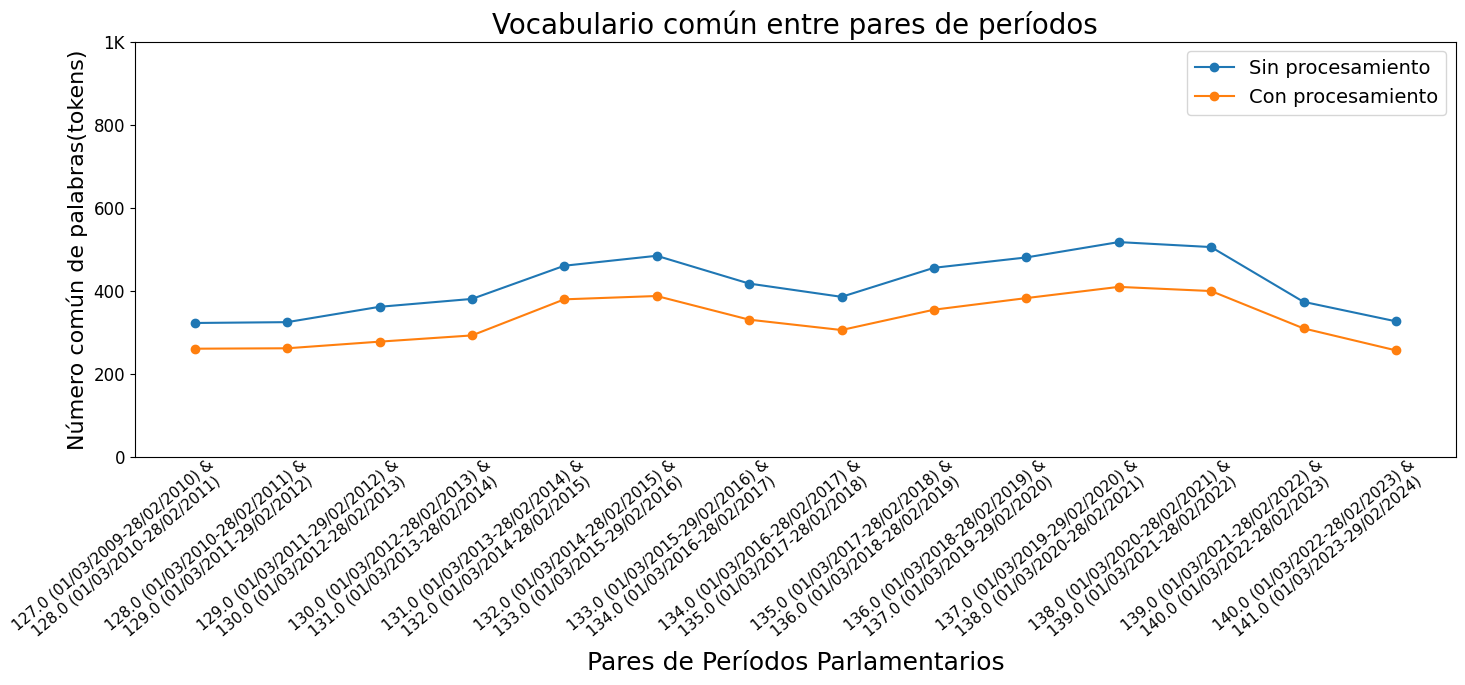

<Figure size 640x480 with 0 Axes>

In [67]:
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
from numerize import numerize 


fig = plt.figure(figsize=(15, 6))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

versions = list(set(todas_versiones_df.version.to_list()))
                
for version in versions:
    
    Y = todas_versiones_df.loc[(todas_versiones_df['version']==version)].comun_vocab.to_list()
    X = todas_versiones_df.loc[(todas_versiones_df['version']==version)]['Periodo intermedio'].to_list()

    plt.plot(X,Y, marker="o")


xticks = comun_vocab_salud_original_df['Periodo intermedio'].unique()
xtick_labels = [ periodos_a_fechas(x) for x in sorted(comun_vocab_salud_original_df['par'].unique()) ]

plt.xlabel('Pares de Períodos Parlamentarios', fontsize=18, labelpad=140)
plt.ylabel('Número común de palabras(tokens)', fontsize=16)

ax = plt.gca()
ax.set_ylim([0,1000])
handles, labels = ax.get_legend_handles_labels()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
plt.title('Vocabulario común entre pares de períodos', fontsize=20)
plt.legend(versions, loc='upper right',prop={'size': 14})

for i, xtick in enumerate(xticks):
    plt.annotate(xtick_labels[i], fontsize=11, annotation_clip=False,  rotation=40,  xy=(xtick, -0.5), ma='center', xytext=(xtick-2,-450))
  
    
#hide major xticks
plt.tick_params(axis='x', which='major', bottom=False, top=False, labelbottom=False)

plt.savefig(RESULTADOS_DIR+'archivos_out/comun_vocab.png')
plt.tight_layout(pad=2)
plt.subplots_adjust(bottom=0.2)
plt.show()
plt.cla()
plt.clf()
fig.clear()

plt.close(fig)


#### Métricas promedio para cada período parlamentario antes del preprocesamiento y después del preprocesamiento

In [68]:
### IL de salud publicadas entres 2010-2023
base_texto_df[base_texto_df['Proyecto_SALUD']==1].shape

(3017, 14)

In [69]:
periodo_salud_normalizado_df.shape

(15, 3)

In [70]:
periodo_salud_normalizado_df.columns

Index(['Periodo', 'Título normalizado', 'vocab'], dtype='object')

In [71]:
metricas ={ 'Sin procesamiento': {
 'Cantidad promedio de tokens': round(periodo_salud_original_df['vocab'].apply(lambda x : len(x)).sum()/periodo_salud_original_df.shape[0],0),
 'Cantidad promedio de tokens únicos': round(len(set(periodo_salud_original_df.vocab.values[0]))/periodo_salud_original_df.shape[0],0) },
 'Con procesamiento': {
 'Cantidad promedio de tokens': round(periodo_salud_normalizado_df['vocab'].apply(lambda x : len(x)).sum()/periodo_salud_normalizado_df.shape[0],0),
 'Cantidad promedio de tokens únicos': round(len(set(periodo_salud_normalizado_df.vocab.values[0]))/periodo_salud_normalizado_df.shape[0],0)}}
metricas

{'Sin procesamiento': {'Cantidad promedio de tokens': 3655.0,
  'Cantidad promedio de tokens únicos': 73.0},
 'Con procesamiento': {'Cantidad promedio de tokens': 1802.0,
  'Cantidad promedio de tokens únicos': 46.0}}

In [72]:
metrica_df = pd.DataFrame.from_dict(metricas, orient= 'index')
metrica_df.to_csv(RESULTADOS_DIR+'archivos_out/metrica_vocab_salud.csv', index=False)
metrica_df

,Cantidad promedio de tokens,Cantidad promedio de tokens únicos
Sin procesamiento,3655.0,73.0
Con procesamiento,1802.0,46.0
